<a href="https://colab.research.google.com/github/AdamZ0112358/values-fifa/blob/main/modeling/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from matplotlib.widgets import Lasso
from sklearn.utils import shuffle
from sklearn.preprocessing import PowerTransformer, RobustScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
pd.set_option('display.float_format', '{:,.4f}'.format)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
df_org = pd.read_excel("/content/drive/MyDrive/ColabNotebooks/eda_fifa_df2.xlsx")

#Linear Regression

I will start by building a simple linear regression model with one variable.
<br> The highest Pearson correlation with log_value has OVA (Overall statistics), so I decided to try to build a linear regression model just with this feature.

In [ ]:
X = df_org.drop('value_log', axis=1)  # Features
y = df_org['value_log']  # Target variable

In [ ]:
#calculate adjusted r-squared
def adj_r2(training_data,r2):
    n = len(training_data) #number of observations
    p = len(training_data.columns) #number of independent features
    return  1-((1-r2)*(n-1)/(n-p-1))

Splitting data into test and training set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model fitting.

In [ ]:
x = X_train['OVA_fixed'].values.reshape(-1,1)
y = y_train.values.reshape(-1,1)

reg_model = LinearRegression()
reg_model.fit(x,y)

reg_pred = reg_model.predict(X_train['OVA_fixed'].values.reshape(-1,1))
reg_RMSE = np.sqrt(mean_squared_error(y_train, reg_pred))
reg_r2 = r2_score(y_train,reg_pred)
reg_adj_r2 = adj_r2(X_train[['OVA_fixed']],reg_r2)

reg_pred_test = reg_model.predict(X_test['OVA_fixed'].values.reshape(-1,1))
reg_RMSE_test = np.sqrt(mean_squared_error(y_test, reg_pred_test))
reg_r2_test = r2_score(y_test,reg_pred_test)
reg_adj_r2_test = adj_r2(X_test,reg_r2_test)

I will add the result of this model to the data frame so that I can easily compare it with other models.

In [ ]:
results = pd.DataFrame(columns=['model', 'adj_r2_train', 'rmse_train', 'adj_r2_test', 'rmse_test'])

In [ ]:
new_row = {'model': 'Linear Regression', 'adj_r2_train': reg_adj_r2,'rmse_train':reg_RMSE, 'adj_r2_test':reg_adj_r2_test, 'rmse_test':reg_RMSE_test }
results = results.append(new_row, ignore_index=True)
results

,model,adj_r2_train,rmse_train,adj_r2_test,rmse_test
0,Linear Regression,0.6040,1.0041,0.5544,1.0362


Basic Linear Regression model has Adjusted R-squared of 0.6040 and Root Mean Squared Error of 1.0041, so it's not the best model for predicting footballers' value.

#Multiple Linear Regression

Let's look at all the variables in the data.

In [ ]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3111 entries, 0 to 3110
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   club                      3111 non-null   object 
 1   footballer                3111 non-null   object 
 2   position                  3111 non-null   object 
 3   height                    3111 non-null   int64  
 4   dominant_leg              3111 non-null   object 
 5   tf_value_eur              3111 non-null   int64  
 6   league                    3111 non-null   object 
 7   age                       3111 non-null   int64  
 8   OVA                       2927 non-null   float64
 9   POT                       2927 non-null   float64
 10  ATTACKING                 2927 non-null   float64
 11  SKILL                     2927 non-null   float64
 12  MOVEMENT                  2927 non-null   float64
 13  POWER                     2927 non-null   float64
 14  MENTALIT

I will use One-Hot Encoding to change categorical feature into numerical. To avoid dummy-variable-trap i should use k-1 dummy variables in each case.

In [ ]:
df_encoded = pd.get_dummies(df_org, columns=['position_grouped', 'league'], drop_first=True)
one_hot_columns = list(set(df_encoded.columns) - set(df_org.columns))

Let's define the initial set of columns that we will use

In [ ]:
sf_col = ['OVA', 'POT', 'ATTACKING', 'SKILL', 'MOVEMENT', 'POWER', 'MENTALITY', 'DEFENDING',
          'TOTAL', 'PAC', 'SHO', 'PAS', 'DRI', 'DEF', 'PHY']
sf_col_fixed = [col + "_fixed" for col in sf_col]

In [ ]:
df = df_encoded[sf_col_fixed + one_hot_columns + ['age', 'ws_average_rating_fixed', 'ws_goals_fixed', 'value_log']].copy()

The data may be arranged in some specific way. Lest's shuffle the set.

In [ ]:
df = shuffle(df, random_state=42)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3111 entries, 693 to 860
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   OVA_fixed                    3111 non-null   float64
 1   POT_fixed                    3111 non-null   float64
 2   ATTACKING_fixed              3111 non-null   float64
 3   SKILL_fixed                  3111 non-null   float64
 4   MOVEMENT_fixed               3111 non-null   float64
 5   POWER_fixed                  3111 non-null   float64
 6   MENTALITY_fixed              3111 non-null   float64
 7   DEFENDING_fixed              3111 non-null   float64
 8   TOTAL_fixed                  3111 non-null   float64
 9   PAC_fixed                    3111 non-null   float64
 10  SHO_fixed                    3111 non-null   float64
 11  PAS_fixed                    3111 non-null   float64
 12  DRI_fixed                    3111 non-null   float64
 13  DEF_fixed        

Splitting data into test set and train set

In [ ]:
X = df.drop('value_log', axis=1)  # Features
y = df['value_log']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Let's put all the selected features into multiple linear regression model and see what it tells us

In [ ]:
X_train = sm.add_constant(X_train)
ks = sm.OLS(y_train, X_train)
ks_res =ks.fit()
ks_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              value_log   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     436.8
Date:                Fri, 18 Aug 2023   Prob (F-statistic):               0.00
Time:                        20:11:58   Log-Likelihood:                -2554.5
No. Observations:                2488   AIC:                             5163.
Df Residuals:                    2461   BIC:                             5320.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.3696      0.438     -0.845      0.398      -1.227       0.488
OVA_fixed                       0.1542      0.007     21.170      0.000       0.140       0.168
POT_fixed                       0.0477      0.006      8.366      0.000       0.036       0.059
ATTACKING_fixed                 0.0055      0.001      4.276      0.000       0.003       0.008
SKILL_fixed                     0.0032      0.001      2.380      0.017       0.001       0.006
MOVEMENT_fixed                  0.0027      0.001      1.810      0.070      -0.000       0.006
POWER_fixed                     0.0051      0.001      3.597      0.000       0.002       0.008
MENTALITY_fixed                 0.0045      0.001      3.227      0.001       0.002       0.007
DEFENDING_fixed                 0.0042      0.002      2.677      0.007       0.001       0.007
TOTAL_fixed                    -0.0050      0.001     -4.338      0.000      -0.007      -0.003
PAC_fixed                       0.0120      0.003      3.611      0.000       0.005       0.019
SHO_fixed                      -0.0024      0.004     -0.586      0.558      -0.010       0.006
PAS_fixed                      -0.0030      0.005     -0.612      0.541      -0.013       0.007
DRI_fixed                       0.0260      0.005      5.158      0.000       0.016       0.036
DEF_fixed                       0.0073      0.005      1.521      0.128      -0.002       0.017
PHY_fixed                       0.0091      0.004      2.171      0.030       0.001       0.017
league_serie a                 -0.0131      0.047     -0.279      0.781      -0.105       0.079
position_grouped_goalkeeper     0.1218      0.342      0.356      0.722      -0.550       0.793
position_grouped_forward        0.1179      0.083      1.417      0.156      -0.045       0.281
league_ligue 1                 -0.0269      0.048     -0.559      0.576      -0.121       0.067
league_laliga                  -0.0262      0.050     -0.522      0.602      -0.125       0.072
position_grouped_midfielder     0.1112      0.056      1.992      0.046       0.002       0.221
league_liga nos                -0.6429      0.050    -12.780      0.000      -0.741      -0.544
league_premier league           0.5747      0.049     11.722      0.000       0.479       0.671
age                            -0.0862      0.006    -15.148      0.000      -0.097      -0.075
ws_average_rating_fixed         0.1513      0.059      2.561      0.010       0.035       0.267
ws_goals_fixed                  0.0520      0.011      4.628      0.000       0.030       0.074
==============================================================================
Omnibus:                      753.904   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarqu

We can see that a lot of features have p-value more than 0.005. It is important to remember that the numerical data are presented at different scales, so it is worth normalizing them to be able to compare them through coefficients

Data scaling

In [ ]:
from sklearn import preprocessing
X_train = X_train.drop(columns=['const'])
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Lets create data frame back to see what features' names are in the bellow model (instead of x1, x2)

In [ ]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [ ]:
y_train = pd.DataFrame(y_train)

In [ ]:
X_train_scaled.index = y_train.index #I don't want to lose indexes

In [ ]:
X_train_scaled = sm.add_constant(X_train_scaled)
model = sm.OLS(y_train, X_train_scaled)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              value_log   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     436.8
Date:                Fri, 18 Aug 2023   Prob (F-statistic):               0.00
Time:                        20:11:58   Log-Likelihood:                -2554.5
No. Observations:                2488   AIC:                             5163.
Df Residuals:                    2461   BIC:                             5320.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           8.7564      0.333     26.267      0.000       8.103       9.410
OVA_fixed                       6.6295      0.313     21.170      0.000       6.015       7.244
POT_fixed                       1.6205      0.194      8.366      0.000       1.241       2.000
ATTACKING_fixed                 2.1030      0.492      4.276      0.000       1.139       3.067
SKILL_fixed                     1.3130      0.552      2.380      0.017       0.231       2.395
MOVEMENT_fixed                  0.8594      0.475      1.810      0.070      -0.072       1.790
POWER_fixed                     1.4552      0.405      3.597      0.000       0.662       2.248
MENTALITY_fixed                 1.5459      0.479      3.227      0.001       0.606       2.485
DEFENDING_fixed                 1.0339      0.386      2.677      0.007       0.276       1.791
TOTAL_fixed                    -7.5246      1.735     -4.338      0.000     -10.926      -4.123
PAC_fixed                       0.7816      0.216      3.611      0.000       0.357       1.206
SHO_fixed                      -0.1637      0.279     -0.586      0.558      -0.711       0.384
PAS_fixed                      -0.1860      0.304     -0.612      0.541      -0.782       0.410
DRI_fixed                       1.5087      0.292      5.158      0.000       0.935       2.082
DEF_fixed                       0.5410      0.356      1.521      0.128      -0.156       1.238
PHY_fixed                       0.5456      0.251      2.171      0.030       0.053       1.038
league_serie a                 -0.0131      0.047     -0.279      0.781      -0.105       0.079
position_grouped_goalkeeper     0.1218      0.342      0.356      0.722      -0.550       0.793
position_grouped_forward        0.1179      0.083      1.417      0.156      -0.045       0.281
league_ligue 1                 -0.0269      0.048     -0.559      0.576      -0.121       0.067
league_laliga                  -0.0262      0.050     -0.522      0.602      -0.125       0.072
position_grouped_midfielder     0.1112      0.056      1.992      0.046       0.002       0.221
league_liga nos                -0.6429      0.050    -12.780      0.000      -0.741      -0.544
league_premier league           0.5747      0.049     11.722      0.000       0.479       0.671
age                            -2.1539      0.142    -15.148      0.000      -2.433      -1.875
ws_average_rating_fixed         0.4222      0.165      2.561      0.010       0.099       0.745
ws_goals_fixed                  1.1442      0.247      4.628      0.000       0.659       1.629
==============================================================================
Omnibus:                      753.904   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarqu

It's easier to look at scaled data. I will now discard features individually with a p-value greater than 0.05

In [ ]:
threshold = 0.05
while result.pvalues.max() > threshold:
    # find highest p-value
    feature_to_drop = result.pvalues.idxmax()
    p_value = result.pvalues.max()
    print(f"dropped feature: {feature_to_drop}, p-value:  {p_value}")

    # remove highest p-value
    X_train_scaled = X_train_scaled.drop(columns=feature_to_drop)


    # Readjust the regression model
    model = sm.OLS(y_train, X_train_scaled)
    result = model.fit()

print(result.summary())

dropped feature: league_serie a, p-value:  0.7805037802451547
dropped feature: position_grouped_goalkeeper, p-value:  0.7236169220485456
dropped feature: league_laliga, p-value:  0.6550901321758836
dropped feature: league_ligue 1, p-value:  0.6892338259055141
dropped feature: SHO_fixed, p-value:  0.6199631252513149
dropped feature: PAS_fixed, p-value:  0.5852583008165964
dropped feature: position_grouped_forward, p-value:  0.17164717646872055
dropped feature: position_grouped_midfielder, p-value:  0.1728287023885884
dropped feature: DEF_fixed, p-value:  0.14330960811403493
                            OLS Regression Results                            
Dep. Variable:              value_log   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     668.2
Date:                Fri, 18 Aug 2023   Prob (F-statistic):               0.00
Time:                    

9 features were discarted

##Multicollinearity

From the previous steps i know that the highest Pearson' correlation wit log_value have: <br>
 - OVA, POT (~0.8) <br>
 - TOT (0.57) <br>
 - POWER, DRI, PAS, MOVEMENT (~0.5)

Let's look at heatmap of Pearson's correlations betweet features.

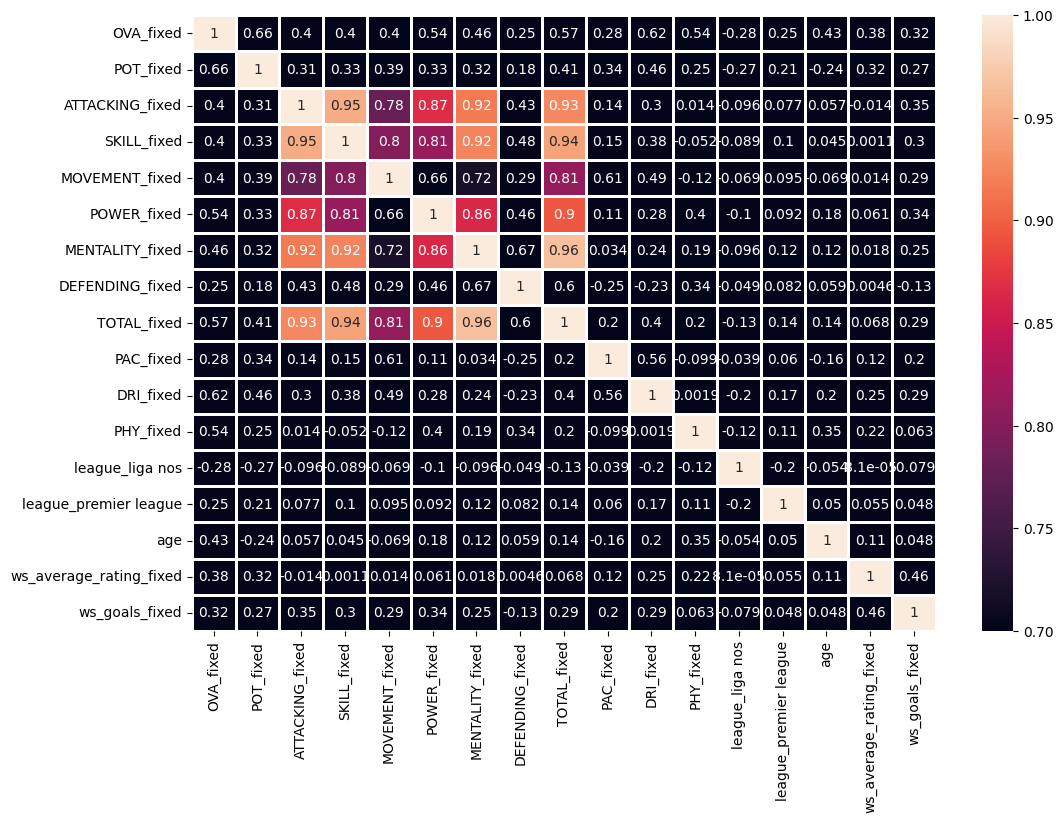

In [ ]:
f, ax = plt.subplots(figsize=(12,8))
sns.heatmap(X_train_scaled.drop('const', axis=1).corr( method='pearson', min_periods=1),annot=True,linewidths=1, vmin=0.7) #I want to single out characteristics with a Pearson coefficient above 0.7
plt.show()

As can be seen above, a square of related features has formed (from ATTACKING to TOTAL).

Let's look at Variance Inflation Factor

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_scaled.drop('const', axis=1).columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled.drop('const', axis=1).values, i)
                          for i in range(len(X_train_scaled.drop('const', axis=1).columns))]

print(vif_data.sort_values(by='VIF', ascending=False))

                    feature        VIF
8               TOTAL_fixed 1,138.9861
6           MENTALITY_fixed   317.6961
3               SKILL_fixed   229.7111
5               POWER_fixed   219.1624
2           ATTACKING_fixed   183.5845
0                 OVA_fixed   157.3124
4            MOVEMENT_fixed   157.2809
11                PHY_fixed   100.5928
10                DRI_fixed    90.2482
9                 PAC_fixed    75.6545
1                 POT_fixed    55.7418
7           DEFENDING_fixed    43.2886
14                      age    17.4496
15  ws_average_rating_fixed    14.9165
16           ws_goals_fixed     2.2242
12          league_liga nos     1.3983
13    league_premier league     1.3395


Let's remove the features with the highest VIF, and check it again.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_scaled.drop(['const', 'TOTAL_fixed', 'MENTALITY_fixed', 'SKILL_fixed', 'MOVEMENT_fixed'], axis=1).columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled.drop(['const', 'TOTAL_fixed', 'MENTALITY_fixed', 'SKILL_fixed', 'MOVEMENT_fixed'], axis=1).values, i)
                          for i in range(len(X_train_scaled.drop(['const', 'TOTAL_fixed', 'MENTALITY_fixed', 'SKILL_fixed', 'MOVEMENT_fixed'], axis=1).columns))]

print(vif_data.sort_values(by='VIF', ascending=False))

                    feature      VIF
0                 OVA_fixed 129.9172
3               POWER_fixed 115.7990
2           ATTACKING_fixed  76.3973
7                 PHY_fixed  54.0887
1                 POT_fixed  53.0541
6                 DRI_fixed  49.8526
5                 PAC_fixed  22.2569
10                      age  17.2287
11  ws_average_rating_fixed  14.2656
4           DEFENDING_fixed  11.3157
12           ws_goals_fixed   2.1601
8           league_liga nos   1.3575
9     league_premier league   1.3219


Again, many indicators have a high VIF, I will try to remove even more features until the VIF drops below 15.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_scaled.drop(['const', 'TOTAL_fixed', 'MENTALITY_fixed', 'SKILL_fixed', 'MOVEMENT_fixed', 'POWER_fixed', 'DRI_fixed', 'PHY_fixed', 'PAC_fixed', 'ATTACKING_fixed', 'age', 'POT_fixed',  'ws_average_rating_fixed'], axis=1).columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled.drop(['const', 'TOTAL_fixed', 'MENTALITY_fixed', 'SKILL_fixed', 'MOVEMENT_fixed', 'POWER_fixed', 'DRI_fixed', 'PHY_fixed', 'PAC_fixed', 'ATTACKING_fixed', 'age', 'POT_fixed', 'ws_average_rating_fixed'], axis=1).values, i)
                          for i in range(len(X_train_scaled.drop(['const', 'TOTAL_fixed', 'MENTALITY_fixed', 'SKILL_fixed', 'MOVEMENT_fixed', 'POWER_fixed', 'DRI_fixed', 'PHY_fixed', 'PAC_fixed', 'ATTACKING_fixed', 'age', 'POT_fixed', 'ws_average_rating_fixed'], axis=1).columns))]

print(vif_data.sort_values(by='VIF', ascending=False))

                 feature    VIF
0              OVA_fixed 6.4389
1        DEFENDING_fixed 5.2517
4         ws_goals_fixed 1.3979
3  league_premier league 1.3020
2        league_liga nos 1.1754


Let's see how the features selected with the VIF will perform in the MLR model.

In [ ]:
X_train_scaled_VIF =  X_train_scaled[['OVA_fixed', 'DEFENDING_fixed', 'ws_goals_fixed', 'league_premier league', 'league_liga nos']]
X_test_scaled_VIF = X_test_scaled[['OVA_fixed', 'DEFENDING_fixed', 'ws_goals_fixed', 'league_premier league', 'league_liga nos']]

In [ ]:
X_train_scaled_VIF = sm.add_constant(X_train_scaled_VIF)
mlr_model = sm.OLS(y_train, X_train_scaled_VIF)
mlr_result = mlr_model.fit()
mlr_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              value_log   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     1067.
Date:                Fri, 18 Aug 2023   Prob (F-statistic):               0.00
Time:                        20:12:00   Log-Likelihood:                -3273.7
No. Observations:                2488   AIC:                             6559.
Df Residuals:                    2482   BIC:                             6594.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    10.4847      0.084    124.458      0.000      10.320      10.650
OVA_fixed                 6.7877      0.148     46.015      0.000       6.498       7.077
DEFENDING_fixed           0.7296      0.068     10.748      0.000       0.597       0.863
ws_goals_fixed            3.2483      0.258     12.603      0.000       2.743       3.754
league_premier league     0.6503      0.050     12.936      0.000       0.552       0.749
league_liga nos          -0.7281      0.051    -14.139      0.000      -0.829      -0.627
==============================================================================
Omnibus:                      133.605   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              178.762
Skew:                          -0.503   Prob(JB):                     1.52e-39
Kurtosis:                       3.844   Cond. No.                         19.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

If I eliminate features based on the VIF analysis, the model will not have a high predictive power. The VIF analysis shows that many characteristics are highly correlated with each other. Perhaps Multiple Linear Regression is not the best model here. <BR>
Nevertheless, I will try to build a model. From the features used so far, I will discard those that affect TOTAL. Of these, TOTAL has the highest correlation with VALUE_log and seems to be the product of the discarded traits (ATTACKING, SKILL, MOVEMENT, POWER, MENTALITY)

I also decided to drop the scored goals feature, because it would give a huge bonus to strikers

## Final MLR model

Using the previously selected features, I will now run the final Multiple Linear Regression model.

In [ ]:
X_train_scaled.drop(['MENTALITY_fixed', 'SKILL_fixed', 'MOVEMENT_fixed', 'POWER_fixed', 'DRI_fixed', 'PHY_fixed', 'PAC_fixed', 'ATTACKING_fixed',  'ws_average_rating_fixed', 'ws_goals_fixed'], axis=1, inplace=True)

In [ ]:
X_test_scaled = X_test_scaled[X_train_scaled.drop(['const'], axis=1).columns]

In [ ]:
mlr_model = sm.OLS(y_train, X_train_scaled)
mlr_result = mlr_model.fit()
mlr_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              value_log   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     1499.
Date:                Fri, 18 Aug 2023   Prob (F-statistic):               0.00
Time:                        20:12:00   Log-Likelihood:                -2642.6
No. Observations:                2488   AIC:                             5301.
Df Residuals:                    2480   BIC:                             5348.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    10.1901      0.073    139.168      0.000      10.047      10.334
OVA_fixed                 7.1064      0.241     29.485      0.000       6.634       7.579
POT_fixed                 1.6124      0.196      8.245      0.000       1.229       1.996
DEFENDING_fixed           0.0044      0.063      0.070      0.944      -0.119       0.128
TOTAL_fixed               1.2766      0.108     11.841      0.000       1.065       1.488
league_liga nos          -0.5915      0.040    -14.687      0.000      -0.670      -0.513
league_premier league     0.5528      0.039     14.148      0.000       0.476       0.629
age                      -2.5676      0.137    -18.733      0.000      -2.836      -2.299
==============================================================================
Omnibus:                      825.173   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4941.437
Skew:                          -1.436   Prob(JB):                         0.00
Kurtosis:                       9.278   Cond. No.                         36.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In this combination of variables, the DEFENDING variable has a p-value greater than 0.05, so I will also discard it.

In [ ]:
X_train_scaled.drop(['DEFENDING_fixed'], axis=1, inplace=True)
X_test_scaled.drop(['DEFENDING_fixed'], axis=1, inplace=True)

<ipython-input-200-b90898113a78>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_scaled.drop(['DEFENDING_fixed'], axis=1, inplace=True)


In [ ]:
mlr_model = sm.OLS(y_train, X_train_scaled)
mlr_result = mlr_model.fit()
mlr_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              value_log   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     1750.
Date:                Fri, 18 Aug 2023   Prob (F-statistic):               0.00
Time:                        20:12:00   Log-Likelihood:                -2642.6
No. Observations:                2488   AIC:                             5299.
Df Residuals:                    2481   BIC:                             5340.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    10.1905      0.073    139.603      0.000      10.047      10.334
OVA_fixed                 7.1050      0.240     29.578      0.000       6.634       7.576
POT_fixed                 1.6125      0.196      8.247      0.000       1.229       1.996
TOTAL_fixed               1.2809      0.088     14.511      0.000       1.108       1.454
league_liga nos          -0.5915      0.040    -14.690      0.000      -0.670      -0.513
league_premier league     0.5529      0.039     14.158      0.000       0.476       0.629
age                      -2.5674      0.137    -18.739      0.000      -2.836      -2.299
==============================================================================
Omnibus:                      825.434   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4944.077
Skew:                          -1.437   Prob(JB):                         0.00
Kurtosis:                       9.280   Cond. No.                         34.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This will be my final Multiple Linear Regression model.

In [ ]:
X_test_scaled = sm.add_constant(X_test_scaled)

In [ ]:
mlr_pred = mlr_result.predict(X_train_scaled)
mlr_RMSE = np.sqrt(mean_squared_error(y_train, mlr_pred))
mlr_r2 = r2_score(y_train,mlr_pred)
mlr_adj_r2 = adj_r2(X_train,mlr_r2)

mlr_pred_test = mlr_result.predict(X_test_scaled)
mlr_RMSE_test = np.sqrt(mean_squared_error(y_test, mlr_pred_test))
mlr_r2_test = r2_score(y_test,mlr_pred_test)
mlr_adj_r2_test = adj_r2(X_test,mlr_r2_test)

In [ ]:
new_row = {'model': 'Multiple Linear Regression', 'adj_r2_train': mlr_adj_r2,'rmse_train':mlr_RMSE, 'adj_r2_test':mlr_adj_r2_test, 'rmse_test':mlr_RMSE_test }
results = results.append(new_row, ignore_index=True)
results

,model,adj_r2_train,rmse_train,adj_r2_test,rmse_test
0,Linear Regression,0.6040,1.0041,0.5544,1.0362
1,Multiple Linear Regression,0.8068,0.6999,0.7346,0.8091


As you can see, final Multiple Linear Regression model has much better predictive power. Higher Adjustet R-Squared and lower Root Mean Squared Error.

Lest's compare predictions with real values

In [ ]:
X_test_scaled.index = X_test.index #matching indexes

In [ ]:
y_pred_train= pd.DataFrame(mlr_result.predict(X_train_scaled)  )
y_pred_test= pd.DataFrame(mlr_result.predict(X_test_scaled) )

In [ ]:
final_mlr = pd.DataFrame()
final_mlr['y_pred'] = y_pred_test.append(y_pred_train)
final_mlr['y_actual'] = pd.DataFrame(y_test).append(y_train)

In [ ]:
pd.set_option('display.float_format', '{:,.0f}'.format) #adjusting number format

In [ ]:
final_mlr['predicted_value'] = np.exp(final_mlr['y_pred'])
final_mlr['actual_value'] = np.exp(final_mlr['y_actual'])
final_mlr['difference'] = final_mlr['actual_value'] - final_mlr['predicted_value']
final_mlr['%_difference'] = ((final_mlr['difference']/final_mlr['actual_value']) * 100).apply(lambda x: f'{x:.2f}%')
final_mlr.drop(['y_pred', 'y_actual'], axis=1, inplace=True)

In [ ]:
final2_mlr = final_mlr.merge(df_org[['club', 'footballer', 'league', 'age', 'OVA_fixed', 'POT_fixed', 'position', 'TOTAL_fixed']], left_index=True, right_index=True, how="left")

In [ ]:
final2_mlr.sort_values(by='difference', ascending=False).head(10)

,predicted_value,actual_value,difference,%_difference,club,footballer,league,age,OVA_fixed,POT_fixed,position,TOTAL_fixed
959,"43,920,249","90,000,000","46,079,751",51.20%,FC Barcelona,Gavi,laliga,18,80,87,Central midfielder,"2,035"
2544,"33,997,930","80,000,000","46,002,070",57.50%,Real Madryt,Rodrygo,laliga,22,81,88,Right forward,"1,967"
1656,"30,628,817","70,000,000","39,371,183",56.24%,Bayern Monachium,Leroy Sane,bundesliga,27,84,84,Left forward,"2,088"
774,"18,070,813","55,000,000","36,929,187",67.14%,Benfika Lizbona,Enzo Fernandez,liga nos,22,80,87,Central midfielder,"2,169"
2679,"29,577,084","65,000,000","35,422,916",54.50%,Bayern Monachium,Serge Gnabry,bundesliga,27,84,84,Right forward,"2,047"
1567,"26,660,629","60,000,000","33,339,371",55.57%,SSC Napoli,Khvicha Kvaratskhelia,serie a,21,79,88,Left forward,"1,949"
293,"57,736,473","90,000,000","32,263,527",35.85%,Real Madryt,Aurelien Tchouameni,laliga,22,83,89,Defensive midfielder,"2,145"
2434,"55,565,587","85,000,000","29,434,413",34.63%,AC Milan,Rafael Leao,serie a,23,84,90,Left forward,"1,971"
2934,"41,515,713","70,000,000","28,484,287",40.69%,SSC Napoli,Victor Osimhen,serie a,24,83,89,Central forward,"1,999"
2296,"32,578,663","60,000,000","27,421,337",45.70%,FC Barcelona,Ousmane Dembele,laliga,25,83,86,Right forward,"2,002"


Above you can see the cases where the model's prediction differs most from the actual values. The overvalued players (according to model) play in a league other than the Premier League, are usually young and have relatively low OVA (overall statistics). Actual values seem to be based more strongly on POT (Potential).

In [ ]:
final2_mlr.sort_values(by='difference', ascending=True).head(10)

,predicted_value,actual_value,difference,%_difference,club,footballer,league,age,OVA_fixed,POT_fixed,position,TOTAL_fixed
793,"337,644,330","170,000,000","-167,644,330",-98.61%,Manchester City,Erling Haaland,premier league,22,89,94,Central forward,"2,127"
1550,"187,102,154","80,000,000","-107,102,154",-133.88%,Manchester City,Kevin De Bruyne,premier league,31,91,91,Attacking midfielder,"2,298"
445,"128,863,192","50,000,000","-78,863,192",-157.73%,Manchester United,Casemiro,premier league,30,89,89,Defensive midfielder,"2,239"
2100,"157,508,414","80,000,000","-77,508,414",-96.89%,FC Liverpool,Mohamed Salah,premier league,30,90,90,Right forward,"2,225"
2596,"149,579,366","75,000,000","-74,579,366",-99.44%,Manchester City,Ruben Dias,premier league,25,88,91,Central defender,"1,894"
2896,"143,882,643","70,000,000","-73,882,643",-105.55%,FC Liverpool,Trent Alexander-Arnold,premier league,24,86,89,Right defender,"2,227"
1613,"240,853,548","180,000,000","-60,853,548",-33.81%,FC Paris Saint-Germain,Kylian Mbappe,ligue 1,24,91,95,Central forward,"2,177"
1414,"130,240,252","70,000,000","-60,240,252",-86.06%,Manchester City,Joao Cancelo,premier league,28,88,88,Right defender,"2,260"
2149,"86,698,354","30,000,000","-56,698,354",-188.99%,Chelsea FC,N'Golo Kante,premier league,31,88,88,Defensive midfielder,"2,144"
2944,"104,446,456","50,000,000","-54,446,456",-108.89%,FC Liverpool,Virgil van Dijk,premier league,31,89,89,Central defender,"2,113"


Above I have filtered out the biggest differences other way round. You can see that according to the model, the best footballers should be worth even more. Probably because the model considers OVERALL statistics from the FIFA game as the most important characteristic. Age is not relevant in this case. Here you can also see the preference of the Premier League over other leagues.

Let's also see what the cross-section of predictions and real values looks like using one club as an example. For this purpose, I have chosen AC Milan.

In [ ]:
final2_mlr[final2_mlr['club'] == "AC Milan"].sort_values(by='difference', ascending=False)

,predicted_value,actual_value,difference,%_difference,club,footballer,league,age,OVA_fixed,POT_fixed,position,TOTAL_fixed
2434,"55,565,587","85,000,000","29,434,413",34.63%,AC Milan,Rafael Leao,serie a,23,84,90,Left forward,"1,971"
2401,"17,659,584","35,000,000","17,340,416",49.54%,AC Milan,Pierre Kalulu,serie a,22,78,85,Central defender,"1,947"
611,"15,949,135","25,000,000","9,050,865",36.20%,AC Milan,Davide Calabria,serie a,26,80,83,Right defender,"2,033"
863,"41,694,052","50,000,000","8,305,948",16.61%,AC Milan,Fikayo Tomori,serie a,25,84,90,Central defender,"1,875"
1144,"33,057,369","40,000,000","6,942,631",17.36%,AC Milan,Ismael Bennacer,serie a,25,82,86,Defensive midfielder,"2,213"
675,"4,796,191","10,000,000","5,203,809",52.04%,AC Milan,Divock Origi,serie a,27,76,77,Central forward,"1,853"
374,"14,944,837","20,000,000","5,055,163",25.28%,AC Milan,Brahim Diaz,serie a,23,78,86,Attacking midfielder,"1,816"
455,"24,991,041","30,000,000","5,008,959",16.70%,AC Milan,Charles De Ketelaere,serie a,21,78,88,Attacking midfielder,"2,067"
2881,"13,418,447","18,000,000","4,581,553",25.45%,AC Milan,Tommaso Pobega,serie a,23,76,85,Central midfielder,"2,133"
2427,"5,614,663","9,000,000","3,385,337",37.61%,AC Milan,Rade Krunic,serie a,29,77,77,Central midfielder,"2,085"


Looking at the data above, some interesting conclusions can be reached:
- it was a mistake to supplement the nulls with the median in a given position at a given club, as can be seen in the example of Emil Roback.
- you can see that the model used age and TOTAL in the prediction - Tonali and Leo have the same OVA, POT and league, yet their value calculated by the model is completely different.
- in my opinion the model incorrectly predicted the value of Rafael Leao (he should be worth even more), but correctly predicted the value of Sandro Tonali, who was recently sold to Newcastle for €75million

# Decision Tree

Let's now focus on the tree-based models.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

It's better not to use one hot encoding in tree-based models <br>
Feature Scaling is also not needed

I will use label encoder to change cateogrical features into numerical

In [ ]:
le_league = LabelEncoder()
le_position = LabelEncoder()

df_org['league_encoded'] = le_league.fit_transform(df_org['league'])
df_org['position_encoded'] = le_position.fit_transform(df_org['position_grouped'])

In [ ]:
dt_df = df_org[sf_col_fixed + ['league_encoded', 'position_encoded', 'age', 'ws_average_rating_fixed', 'ws_goals_fixed', 'value_log']].copy()

Splitting the set again.

In [ ]:
X = dt_df.drop('value_log', axis=1)  # Features
y = dt_df['value_log']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Creating a Decision Tree Regressor model

In [ ]:
decision_tree_reg = DecisionTreeRegressor(random_state=42)
dt_result = decision_tree_reg.fit(X_train, y_train)


In [ ]:
dt_pred = dt_result.predict(X_train)
dt_RMSE = np.sqrt(mean_squared_error(y_train, dt_pred))

dt_r2 = r2_score(y_train,dt_pred)
dt_adj_r2 = adj_r2(X_train,dt_r2)
print(f"RMSE: {dt_RMSE:.4f}")
print(f"adj_r2: {dt_adj_r2:.4f}")

dt_pred_test = dt_result.predict(X_test)
dt_RMSE_test = np.sqrt(mean_squared_error(y_test, dt_pred_test))
dt_r2_test = r2_score(y_test,dt_pred_test)
dt_adj_r2_test = adj_r2(X_test,dt_r2_test)
print(f"RMSE_test: {dt_RMSE_test:.4f}")
print(f"adj_r2_test: {dt_adj_r2_test:.4f}")


RMSE: 0.0160
adj_r2: 0.9999
RMSE_test: 0.8592
adj_r2_test: 0.7114


It can be seen that the model is concerned with the problem of overfitting. The prediction is almost perfect for the training data, but the model does not perform well on the new data. <br>
I will try to adjust the parameters using GridSearch.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Looking for the best hyperparameters using Grid Search
param_grid = {
    'max_depth': [3, 6, 9, 12],
    'min_samples_split': [5, 20, 40, 60],
    'min_samples_leaf': [2, 4, 6, 8, 10],
    'max_leaf_nodes' : [5, 50, 100, 150]
}

grid_search = GridSearchCV(estimator=DecisionTreeRegressor(),
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("The best hyperparameters:", best_params)

The best hyperparameters: {'max_depth': 12, 'max_leaf_nodes': 100, 'min_samples_leaf': 6, 'min_samples_split': 40}


In [ ]:
# Application of optimal parameters
max_depth = 12
max_leaf_nodes = 100
min_samples_leaf = 6
min_samples_split = 40

# Create a new instance of Decision Tree Regressor model with optimal parameters
decision_tree_reg_optimal = DecisionTreeRegressor(max_depth=max_depth,
                                                  max_leaf_nodes=max_leaf_nodes,
                                                  min_samples_leaf=min_samples_leaf,
                                                  min_samples_split=min_samples_split)

In [ ]:
dt_result2 = decision_tree_reg_optimal.fit(X_train, y_train)

In [ ]:
dt_pred = dt_result2.predict(X_train)
dt_RMSE = np.sqrt(mean_squared_error(y_train, dt_pred))

dt_r2 = r2_score(y_train,dt_pred)
dt_adj_r2 = adj_r2(X_train,dt_r2)
print(f"RMSE: {dt_RMSE:.4f}")
print(f"adj_r2: {dt_adj_r2:.4f}")

dt_pred_test = dt_result2.predict(X_test)
dt_RMSE_test = np.sqrt(mean_squared_error(y_test, dt_pred_test))
dt_r2_test = r2_score(y_test,dt_pred_test)
dt_adj_r2_test = adj_r2(X_test,dt_r2_test)
print(f"RMSE_test: {dt_RMSE_test:.4f}")
print(f"adj_r2_test: {dt_adj_r2_test:.4f}")


RMSE: 0.6086
adj_r2: 0.8534
RMSE_test: 0.7354
adj_r2_test: 0.7886


Overfitting problem is reduced, model works better on test data.

Let's calculate Feature Importance and remove features that are not useful for prediction

In [ ]:
pd.set_option('display.float_format', '{:,.4f}'.format) #adjusting number format

In [ ]:
feature_importance = decision_tree_reg_optimal.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Feature filtering with Importance below 0.01
low_importance_features = feature_importance_df[feature_importance_df['Importance'] < 0.01]['Feature'].tolist()

print("Feature importance:")
print(feature_importance_df)
print(low_importance_features)

Feature importance:
                    Feature  Importance
0                 OVA_fixed      0.6176
1                 POT_fixed      0.2333
17                      age      0.0832
15           league_encoded      0.0213
5               POWER_fixed      0.0131
6           MENTALITY_fixed      0.0117
4            MOVEMENT_fixed      0.0039
7           DEFENDING_fixed      0.0026
18  ws_average_rating_fixed      0.0024
19           ws_goals_fixed      0.0023
13                DEF_fixed      0.0022
9                 PAC_fixed      0.0022
2           ATTACKING_fixed      0.0015
3               SKILL_fixed      0.0012
8               TOTAL_fixed      0.0011
12                DRI_fixed      0.0005
11                PAS_fixed      0.0000
14                PHY_fixed      0.0000
16         position_encoded      0.0000
10                SHO_fixed      0.0000
['MOVEMENT_fixed', 'DEFENDING_fixed', 'ws_average_rating_fixed', 'ws_goals_fixed', 'DEF_fixed', 'PAC_fixed', 'ATTACKING_fixed', 'SKILL_fixed

In [ ]:
X_train.drop(low_importance_features, axis=1, inplace=True)
X_test.drop(low_importance_features, axis=1, inplace=True)

In [ ]:
dt_result3 = decision_tree_reg_optimal.fit(X_train, y_train)

In [ ]:
dt_pred = dt_result3.predict(X_train)
dt_RMSE = np.sqrt(mean_squared_error(y_train, dt_pred))

dt_r2 = r2_score(y_train,dt_pred)
dt_adj_r2 = adj_r2(X_train,dt_r2)

dt_pred_test = dt_result3.predict(X_test)
dt_RMSE_test = np.sqrt(mean_squared_error(y_test, dt_pred_test))
dt_r2_test = r2_score(y_test,dt_pred_test)
dt_adj_r2_test = adj_r2(X_test,dt_r2_test)

In [ ]:
new_row = {'model': 'Decision Tree', 'adj_r2_train': dt_adj_r2,'rmse_train':dt_RMSE, 'adj_r2_test':dt_adj_r2_test, 'rmse_test':dt_RMSE_test }
results = results.append(new_row, ignore_index=True)
results

,model,adj_r2_train,rmse_train,adj_r2_test,rmse_test
0,Linear Regression,0.6040,1.0041,0.5544,1.0362
1,Multiple Linear Regression,0.8068,0.6999,0.7346,0.8091
2,Decision Tree,0.8509,0.6154,0.7849,0.7505


So far Decision Tree has the best score of all models.
<br>An adjusted R-squared of 0.7914 suggests that around 79.14% of the variability in the target variable is explained by the predictors in the model when applied to the test data.
Decision Tree model maintains a relatively strong performance on unseen data, though slightly lower than its performance on the training data.
<br>  The model's predictions are reasonably accurate

#Random Forest

Let us now try a more advanced tree-based model - the random forest.

In [ ]:
rf_df = dt_df.copy()

In [ ]:
X = rf_df.drop('value_log', axis=1)  # Features
y = rf_df['value_log']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

First random forest model

In [ ]:
random_forest = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

rf_result = random_forest.fit(X_train, y_train)

In [ ]:
rf_pred = rf_result.predict(X_train)
rf_RMSE = np.sqrt(mean_squared_error(y_train, rf_pred))
rf_r2 = r2_score(y_train,rf_pred)
rf_adj_r2 = adj_r2(X_train,rf_r2)
print(f"RMSE: {rf_RMSE:.4f}")
print(f"adj_r2: {rf_adj_r2:.4f}")

rf_pred_test = rf_result.predict(X_test)
rf_RMSE_test = np.sqrt(mean_squared_error(y_test, rf_pred_test))
rf_r2_test = r2_score(y_test,rf_pred_test)
rf_adj_r2_test = adj_r2(X_test,rf_r2_test)
print(f"RMSE_test: {rf_RMSE_test:.4f}")
print(f"adj_r2_test: {rf_adj_r2_test:.4f}")

RMSE: 0.3641
adj_r2: 0.9475
RMSE_test: 0.6566
adj_r2_test: 0.8315


As in the decision tree, we see that there is an overfitting problem.

## Hyperparameters Selection

I will try using GridSearch to look for suitable hyperparameters

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

random_forest_reg = RandomForestRegressor()

param_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': [8, 12, 14],
    'min_samples_split': [10, 20, 40],
    'min_samples_leaf': [2, 4, 6],
    'max_leaf_nodes' : [100, 150, 200]
}

grid_search = GridSearchCV(estimator=random_forest_reg, param_grid=param_grid, cv=3)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)


Best hyperparameters: {'max_depth': 12, 'max_leaf_nodes': 150, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 400}


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Calculated optimal parameters of the random forest
max_depth = 12
max_leaf_nodes = 200
min_samples_leaf = 2
min_samples_split = 10
n_estimators=200


random_forest_reg_optimal = RandomForestRegressor(n_estimators=n_estimators,
                                                  max_depth=max_depth,
                                                  max_leaf_nodes=max_leaf_nodes,
                                                  min_samples_leaf=min_samples_leaf,
                                                  min_samples_split=min_samples_split,
                                                  bootstrap=True)

In [ ]:
rf_result2 = random_forest_reg_optimal.fit(X_train, y_train)

In [ ]:
rf_pred = rf_result2.predict(X_train)
rf_RMSE = np.sqrt(mean_squared_error(y_train, rf_pred))
rf_r2 = r2_score(y_train,rf_pred)
rf_adj_r2 = adj_r2(X_train,rf_r2)
print(f"RMSE: {rf_RMSE:.4f}")
print(f"adj_r2: {rf_adj_r2:.4f}")

rf_pred_test = rf_result2.predict(X_test)
rf_RMSE_test = np.sqrt(mean_squared_error(y_test, rf_pred_test))
rf_r2_test = r2_score(y_test,rf_pred_test)
rf_adj_r2_test = adj_r2(X_test,rf_r2_test)
print(f"RMSE_test: {rf_RMSE_test:.4f}")
print(f"adj_r2_test: {rf_adj_r2_test:.4f}")

RMSE: 0.4160
adj_r2: 0.9315
RMSE_test: 0.6520
adj_r2_test: 0.8338


When GridSearch is applied, the results look slightly better than when using random hyperparameters, however GridSeach takes too much time, so let's try RandomSearch.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

# Create an instance of the Random Forest Regressor model
random_forest_reg = RandomForestRegressor()

# Defining the hyperparameter space to be searched
param_dist = {
    'n_estimators': sp_randint(10, 200),
    'max_features': ['auto', 'sqrt'],
    'max_depth': sp_randint(1, 20),
    'min_samples_split': sp_randint(2, 20),
    'min_samples_leaf': sp_randint(1, 20),
    'max_leaf_nodes' : sp_randint(50, 200),
    'bootstrap': [True, False]
}

# Create an instance of RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=random_forest_reg, param_distributions=param_dist, n_iter=100,
                                   cv=5, random_state=42, n_jobs=-1)

# Fitting the model to the training data using RandomizedSearchCV
random_search.fit(X_train, y_train)

# We choose the optimal hyperparameters
best_params = random_search.best_params_


In [ ]:
print("Best hyperparameters:", best_params)

# Fitting a model with optimal hyperparameters
best_random_forest_reg = RandomForestRegressor(**best_params)
rf_result3 = best_random_forest_reg.fit(X_train, y_train)


rf_pred = rf_result3.predict(X_train)
rf_RMSE = np.sqrt(mean_squared_error(y_train, rf_pred))
rf_r2 = r2_score(y_train,rf_pred)
rf_adj_r2 = adj_r2(X_train,rf_r2)
print(f"RMSE: {rf_RMSE:.4f}")
print(f"adj_r2: {rf_adj_r2:.4f}")

rf_pred_test = rf_result3.predict(X_test)
rf_RMSE_test = np.sqrt(mean_squared_error(y_test, rf_pred_test))
rf_r2_test = r2_score(y_test,rf_pred_test)
rf_adj_r2_test = adj_r2(X_test,rf_r2_test)
print(f"RMSE_test: {rf_RMSE_test:.4f}")
print(f"adj_r2_test: {rf_adj_r2_test:.4f}")

Best hyperparameters: {'max_depth': 12, 'max_leaf_nodes': 100, 'min_samples_leaf': 6, 'min_samples_split': 40}
RMSE: 0.5693
adj_r2: 0.8717
RMSE_test: 0.6920
adj_r2_test: 0.8128


Using GridSearch and RandomSearch, the models produce similar results. Taking into account the various metrics, GridSearch Model appears to perform slightly better overall. It has lower RMSE and higher adjusted R-squared on the training set, suggesting better performance in explaining the training data. Additionally, GridSearch Model's adjusted R-squared on the test set is slightly higher, indicating it might have a better fit to new, unseen data as well.

## Feature Selection

Using cross validation I will find the best features for the random forest model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV

# Fitting the RandomForest model with optimal hyperparameters
random_forest = RandomForestRegressor(**best_params)

# Create a feature selector using crosvalidation
rfecv = RFECV(estimator=random_forest, cv=5)

# Matching the feature selector to the training data
rfecv.fit(X_train, y_train)

# We choose the best features
selected_features = X_train.columns[rfecv.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['OVA_fixed', 'POT_fixed', 'POWER_fixed', 'TOTAL_fixed',
       'league_encoded', 'age'],
      dtype='object')


I will also check what the Feature Importance Analysis shows

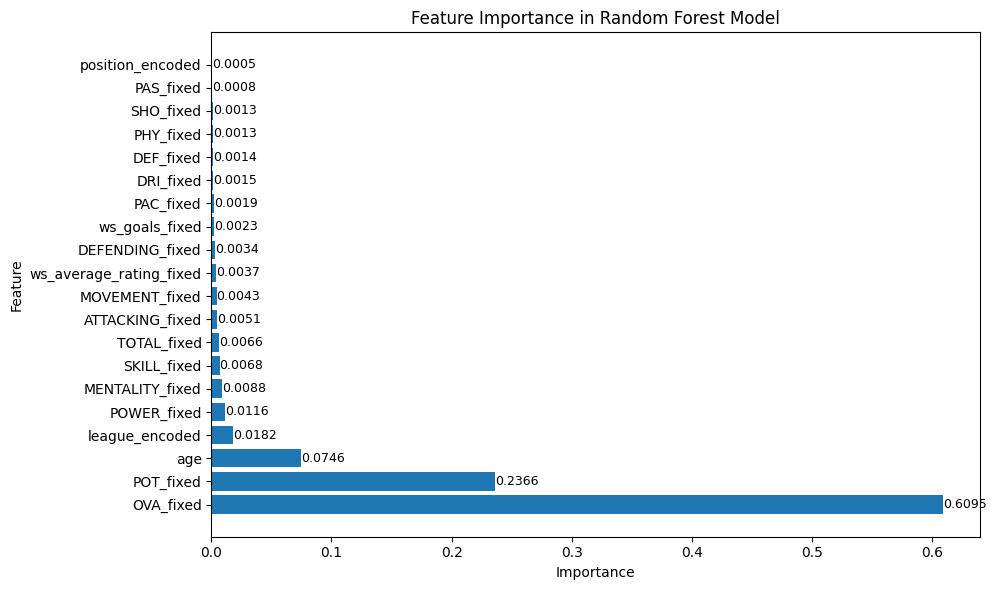

In [ ]:
# Fitting the RandomForest model with optimal hyperparameters (assuming you already have the best_params defined)
random_forest = RandomForestRegressor(**best_params)
random_forest.fit(X_train, y_train)

# Feature Importance Analysis
feature_importance = random_forest.feature_importances_
feature_names = X_train.columns

# Creating a DataFrame with feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualizing feature importance with a bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.tight_layout()

# Adding value labels to each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.4f}',
             ha='left', va='center', fontsize=9)

plt.show()

The selected features more or less coincide with each other. I will finally use those from cross validation

## Final RF Model

Using the previously selected features and hiperparameters, I will now run the final Random Forest model.

In [ ]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [ ]:
# Calculated optimal parameters of the random forest
max_depth = 12
max_leaf_nodes = 200
min_samples_leaf = 2
min_samples_split = 10
n_estimators=200


random_forest_reg_optimal = RandomForestRegressor(n_estimators=n_estimators,
                                                  max_depth=max_depth,
                                                  max_leaf_nodes=max_leaf_nodes,
                                                  min_samples_leaf=min_samples_leaf,
                                                  min_samples_split=min_samples_split,
                                                  bootstrap=True)

In [ ]:
rf_result4 = random_forest_reg_optimal.fit(X_train, y_train)


rf_pred = rf_result4.predict(X_train)
rf_RMSE = np.sqrt(mean_squared_error(y_train, rf_pred))
rf_r2 = r2_score(y_train,rf_pred)
rf_adj_r2 = adj_r2(X_train,rf_r2)
print(f"RMSE: {rf_RMSE:.4f}")
print(f"adj_r2: {rf_adj_r2:.4f}")

rf_pred_test = rf_result4.predict(X_test)
rf_RMSE_test = np.sqrt(mean_squared_error(y_test, rf_pred_test))
rf_r2_test = r2_score(y_test,rf_pred_test)
rf_adj_r2_test = adj_r2(X_test,rf_r2_test)
print(f"RMSE_test: {rf_RMSE_test:.4f}")
print(f"adj_r2_test: {rf_adj_r2_test:.4f}")

RMSE: 0.4508
adj_r2: 0.9200
RMSE_test: 0.6378
adj_r2_test: 0.8446


The model is no longer overfitted, although it has slightly better results on training data.

In [ ]:
new_row = {'model': 'Random Forest', 'adj_r2_train': rf_adj_r2,'rmse_train':rf_RMSE, 'adj_r2_test':rf_adj_r2_test, 'rmse_test':rf_RMSE_test }
results = results.append(new_row, ignore_index=True)
results

,model,adj_r2_train,rmse_train,adj_r2_test,rmse_test
0,Linear Regression,0.6040,1.0041,0.5544,1.0362
1,Multiple Linear Regression,0.8068,0.6999,0.7346,0.8091
2,Decision Tree,0.8509,0.6154,0.7849,0.7505
3,Random Forest,0.9200,0.4508,0.8446,0.6378


As you can see, the random forest has by far the best results.
<br>This model exhibits strong performance across both training and test datasets. With a training RMSE of 0.4508 and an adjusted R-squared of 0.9200, it demonstrates effective fitting to the training data. Moreover, its test RMSE of 0.6378 and adjusted R-squared of 0.8446 indicate its ability to generalize well to new, unseen data. This suggests a robust and well-balanced model with a good balance between predictive accuracy and generalization.

Lest's predict target values.

In [ ]:
y_pred_train = pd.DataFrame(rf_result4.predict(X_train) )
y_pred_test = pd.DataFrame(rf_result4.predict(X_test) )

In [ ]:
#I need the same indexes
y_pred_test.index = X_test.index
y_pred_train.index = X_train.index

Lest's compare predictions with real values

In [ ]:
final_RF = pd.DataFrame()
final_RF['y_pred'] = y_pred_test.append(y_pred_train)
final_RF['y_actual'] = pd.DataFrame(y_test).append(pd.DataFrame(y_train))

In [ ]:
final_RF['predicted_value'] = np.exp(final_RF['y_pred'])
final_RF['actual_value'] = np.exp(final_RF['y_actual'])
final_RF['difference'] = final_RF['actual_value'] - final_RF['predicted_value']
final_RF['%_difference'] = ((final_RF['difference']/final_RF['actual_value']) * 100).apply(lambda x: f'{x:.2f}%')
final_RF.drop(['y_pred', 'y_actual'], axis=1, inplace=True)
final_RF2 = final_RF.merge(df_org[['club', 'footballer', 'league', 'age', 'OVA_fixed', 'POT_fixed', 'position', 'TOTAL_fixed']], left_index=True, right_index=True, how="left")

In [ ]:
pd.set_option('display.float_format', '{:,.0f}'.format) #adjusting number format

In [ ]:
final_RF2.sort_values(by='difference', ascending=False).head(10)

,predicted_value,actual_value,difference,%_difference,club,footballer,league,age,OVA_fixed,POT_fixed,position,TOTAL_fixed
1613,"117,388,197","180,000,000","62,611,803",34.78%,FC Paris Saint-Germain,Kylian Mbappe,ligue 1,24,91,95,Central forward,"2,177"
793,"119,144,789","170,000,000","50,855,211",29.91%,Manchester City,Erling Haaland,premier league,22,89,94,Central forward,"2,127"
959,"46,516,754","90,000,000","43,483,246",48.31%,FC Barcelona,Gavi,laliga,18,80,87,Central midfielder,"2,035"
1656,"32,227,905","70,000,000","37,772,095",53.96%,Bayern Monachium,Leroy Sane,bundesliga,27,84,84,Left forward,"2,088"
1460,"73,248,508","110,000,000","36,751,492",33.41%,Borussia Dortmund,Jude Bellingham,bundesliga,19,85,91,Central midfielder,"2,188"
416,"63,887,748","100,000,000","36,112,252",36.11%,FC Arsenal,Bukayo Saka,premier league,21,83,90,Right midfielder,"2,110"
1184,"34,982,475","70,000,000","35,017,525",50.03%,Manchester City,Jack Grealish,premier league,27,84,84,Left forward,"2,017"
2544,"46,216,748","80,000,000","33,783,252",42.23%,Real Madryt,Rodrygo,laliga,22,81,88,Right forward,"1,967"
2679,"32,289,116","65,000,000","32,710,884",50.32%,Bayern Monachium,Serge Gnabry,bundesliga,27,84,84,Right forward,"2,047"
1742,"43,515,370","75,000,000","31,484,630",41.98%,FC Liverpool,Luis Diaz,premier league,26,84,85,Left forward,"2,049"


Shown above are the most overvalued footballers according to the Random Forest model. Most of them are the most expensive footballers according to transfermarkt (for example Mbappe, Haaland, Bellingham), so the most expensive ones are depreciated by the model. Perhaps the model doesn't deal well with outliers.
<br>Another thing worth noting seems to be that the model generally undervalues footballers relative to real values (to be checked).

In [ ]:
final_RF2.sort_values(by='difference', ascending=True).head(10)

,predicted_value,actual_value,difference,%_difference,club,footballer,league,age,OVA_fixed,POT_fixed,position,TOTAL_fixed
926,"101,711,431","50,000,000","-51,711,431",-103.42%,FC Barcelona,Frenkie de Jong,laliga,25,87,92,Central midfielder,"2,238"
1010,"25,091,233","5,000,000","-20,091,233",-401.82%,Real Valladolid CF,Gonzalo Plata,laliga,22,77,86,Right forward,"1,925"
2642,"68,989,721","50,000,000","-18,989,721",-37.98%,AC Milan,Sandro Tonali,serie a,22,84,90,Defensive midfielder,"2,225"
2370,"43,220,716","25,000,000","-18,220,716",-72.88%,Sporting CP,Pedro Porro,liga nos,23,82,88,Right defender,"2,157"
2034,"37,186,383","20,000,000","-17,186,383",-85.93%,FC Barcelona,Memphis Depay,laliga,28,85,85,Central forward,"2,089"
1875,"19,655,172","3,000,000","-16,655,172",-555.17%,Real Madryt,Mariano Diaz,laliga,29,84,86,Central forward,"2,039"
445,"65,865,653","50,000,000","-15,865,653",-31.73%,Manchester United,Casemiro,premier league,30,89,89,Defensive midfielder,"2,239"
1276,"40,497,357","25,000,000","-15,497,357",-61.99%,Bayer 04 Leverkusen,Jeremie Frimpong,bundesliga,22,81,87,Right defender,"2,054"
634,"34,652,797","20,000,000","-14,652,797",-73.26%,Chelsea FC,Denis Zakaria,premier league,26,81,86,Defensive midfielder,"2,052"
643,"36,136,819","22,000,000","-14,136,819",-64.26%,Udinese Calcio,Destiny Udogie,serie a,20,76,89,Left defender,"1,977"


Now let's look at the undervalued players. Interestingly, the value of many of the above players has actually increased (data was collected 7 months ago): De Jong is now worth €75mln, Tonali moved to Newcastle for that price and Frimpong is now worth €40mln.
On the other hand, Casemiro's value has dropped by €10mln and Mariano Diaz is currently without a club and worth €2.5mln.

Let's see if the model actually underestimates the value of footballers in general.

In [ ]:
median_mean = final_RF2.agg({'predicted_value': ['median', 'mean'], 'actual_value': ['median', 'mean']})
print(median_mean)

        predicted_value  actual_value
median        3,106,280     3,500,000
mean          8,018,044     8,981,614


Both the median and mean values are lower in the predicted_value for the whole set.

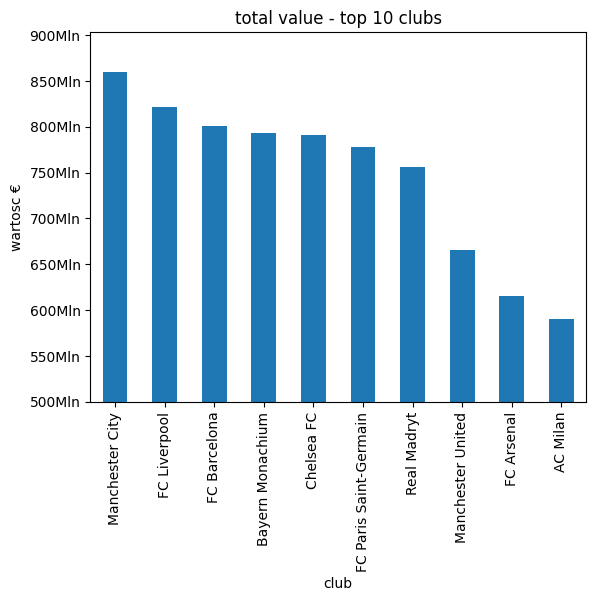

In [ ]:
import matplotlib.ticker as ticker

club_sum_price = final_RF2.groupby(['club'])['predicted_value'].sum().sort_values(ascending=False).head(10)
ax = club_sum_price.plot.bar(x='club', y='predicted_value')
ax.set_title("total value - top 10 clubs")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,g}'.format(y/1000000) + 'Mln'))
ax.set_ybound(lower=500000000, upper=None)
ax.set_ylabel("wartosc €", fontdict=None, labelpad=None)
plt.show()

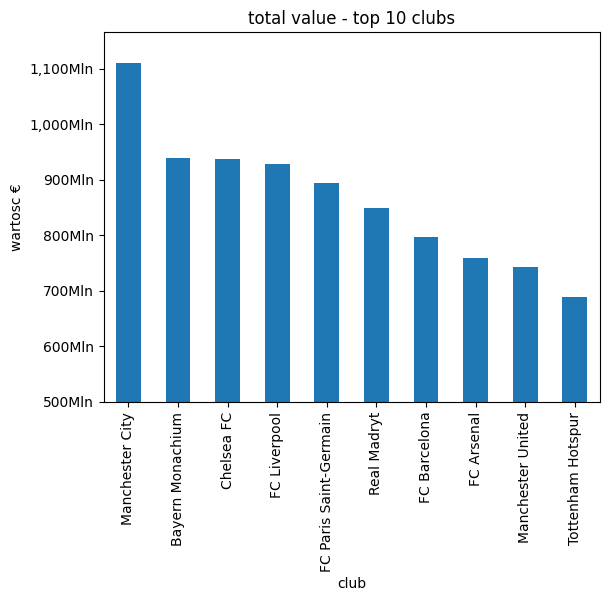

In [ ]:
import matplotlib.ticker as ticker

club_sum_price = final_RF2.groupby(['club'])['actual_value'].sum().sort_values(ascending=False).head(10)
ax = club_sum_price.plot.bar(x='club', y='predicted_value')
ax.set_title("total value - top 10 clubs")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,g}'.format(y/1000000) + 'Mln'))
ax.set_ybound(lower=500000000, upper=None)
ax.set_ylabel("wartosc €", fontdict=None, labelpad=None)
plt.show()

Looking at the top 10 clubs in terms of the sum of the value of the players, the difference is even more evident. Footballers who were worth a lot have generally lost value.

Let's also see what the cross-section of predictions and real values looks like using one club as an example. To be consistent with an earlier choice this time it will again be AC Milan.

In [ ]:
search_value = 'Milan'
final_RF2[final_RF2['club'].str.contains(search_value, regex=False)].sort_values(by='difference', ascending=False)

,predicted_value,actual_value,difference,%_difference,club,footballer,league,age,OVA_fixed,POT_fixed,position,TOTAL_fixed
2434,"64,551,593","85,000,000","20,448,407",24.06%,AC Milan,Rafael Leao,serie a,23,84,90,Left forward,"1,971"
2401,"22,939,995","35,000,000","12,060,005",34.46%,AC Milan,Pierre Kalulu,serie a,22,78,85,Central defender,"1,947"
1144,"35,478,749","40,000,000","4,521,251",11.30%,AC Milan,Ismael Bennacer,serie a,25,82,86,Defensive midfielder,"2,213"
2427,"6,626,206","9,000,000","2,373,794",26.38%,AC Milan,Rade Krunic,serie a,29,77,77,Central midfielder,"2,085"
675,"7,673,849","10,000,000","2,326,151",23.26%,AC Milan,Divock Origi,serie a,27,76,77,Central forward,"1,853"
611,"22,995,480","25,000,000","2,004,520",8.02%,AC Milan,Davide Calabria,serie a,26,80,83,Right defender,"2,033"
1974,"5,614,933","7,000,000","1,385,067",19.79%,AC Milan,Matteo Gabbia,serie a,23,72,81,Central defender,"1,605"
1896,"2,311,649","3,000,000","688,351",22.95%,AC Milan,Marko Lazetic,serie a,18,65,85,Central forward,"1,659"
899,"3,015,699","3,500,000","484,301",13.84%,AC Milan,Fode Ballo-Toure,serie a,26,72,75,Left defender,"1,881"
2278,"3,590,880","4,000,000","409,120",10.23%,AC Milan,Olivier Giroud,serie a,36,82,82,Central forward,"1,928"


In contrast to Multiple Linear Regression, the Random Forest model did much better with values where the data was supplemented (an example is provided by Emil Roback).
<br>This model also shows that age and TOTAL are taken into account: Tonali is one year younger and has more in TOTAL than Leao and thus was valued higher.

Let's now play AC Milan manager and see who we could bring into the team. So it should be an undervalued player who will fit into AC Milan's tactics. As a supporter of this team, I know that the biggest lack was a right winger.

In [ ]:
search_value = 'Right forward'
final_RF2[final_RF2['position'].str.contains(search_value, regex=False)].sort_values(by='difference', ascending=True).head(10)

,predicted_value,actual_value,difference,%_difference,club,footballer,league,age,OVA_fixed,POT_fixed,position,TOTAL_fixed
1010,"25,091,233","5,000,000","-20,091,233",-401.82%,Real Valladolid CF,Gonzalo Plata,laliga,22,77,86,Right forward,"1,925"
683,"31,834,950","23,000,000","-8,834,950",-38.41%,US Sassuolo,Domenico Berardi,serie a,28,84,84,Right forward,"2,062"
482,"44,927,251","38,000,000","-6,927,251",-18.23%,Chelsea FC,Christian Pulisic,premier league,24,82,88,Right forward,"1,950"
1971,"11,913,397","5,000,000","-6,913,397",-138.27%,Lazio Rzym,Matteo Cancellieri,serie a,20,73,86,Right forward,"1,874"
2327,"13,453,597","8,000,000","-5,453,597",-68.17%,VfL Wolfsburg,Patrick Wimmer,bundesliga,21,76,84,Right forward,"1,904"
1845,"29,754,762","25,000,000","-4,754,762",-19.02%,Real Madryt,Marco Asensio,laliga,26,83,84,Right forward,"2,036"
654,"7,107,790","2,500,000","-4,607,790",-184.31%,SC Braga,Diego Lainez,liga nos,22,74,83,Right forward,"1,861"
134,"17,960,951","15,000,000","-2,960,951",-19.74%,AC Milan,Alexis Saelemaekers,serie a,23,78,82,Right forward,"2,035"
529,"6,438,151","4,000,000","-2,438,151",-60.95%,Leeds United,Crysencio Summerville,premier league,21,71,82,Right forward,"1,688"
2625,"22,134,406","20,000,000","-2,134,406",-10.67%,Villarreal CF,Samuel Chukwueze,laliga,23,79,85,Right forward,"1,898"


Interestingly, I always thought Domenico Berardi was a great footballer who would have done well at a better club than Sasuolo.
What is even more interesting is that AC Milan have really brought in two right-wingers in this transfer window. Both are listed above, and they are Christian Pulisic and Samuel Chukwueze.

# Summary

To sum up the entire project:
1. I used web scraping to pull data from 3 different sources, the hardest part was combining these 3 sources into one data set.
2. I did an Explanatory Data Analysis, in which I examined the target variable - the value of the football players, as well as the independent variables.
3. I trained Data Science models to determine the true value of footballers based on their characteristics from the fifa game. The models along with their results can be found in the table below.

In [ ]:
pd.set_option('display.float_format', '{:,.4f}'.format) #adjusting number format
results

,model,adj_r2_train,rmse_train,adj_r2_test,rmse_test
0,Linear Regression,0.6040,1.0041,0.5544,1.0362
1,Multiple Linear Regression,0.8068,0.6999,0.7346,0.8091
2,Decision Tree,0.8509,0.6154,0.7849,0.7505
3,Random Forest,0.9200,0.4508,0.8446,0.6378


By far the best model turned out to be Random Forest.
<br>The adjusted R-squared (adj_r2) value of 0.9200 on the training dataset implies that approximately 92.00% of the variability in the target variable can be explained by the model's predictors. <br>Furthermore, the adjusted R-squared value of 0.8446 on the test dataset signifies that the model remains effective in explaining the variability in the target variable even when applied to new and unseen data.
<br>The Root Mean Squared Error (RMSE) value of 0.4508 indicates that, on average, the model's predictions are off by approximately 0.4508 units from the actual values in the training dataset.
<br>When evaluated on the test dataset, the RMSE of 0.6378 suggests that the model's predictions have a similar level of accuracy to the training dataset, with a slight increase in prediction error.

The hyperparameters of the model were selected using GridSearch.  Features were selected using cross validation and can be found below.

In [ ]:
selected_features

Index(['OVA_fixed', 'POT_fixed', 'POWER_fixed', 'TOTAL_fixed',
       'league_encoded', 'age'],
      dtype='object')

It turned out that none of the characteristics from the who_scored dataset were used in the final model. This does not bother me, however, as this project was primarily intended to practice various data processing exercises.
<br>Perhaps with a different approach (halfway through the project I decided to fill in the data instead of removing the nulls) the who_scored set would have more predictive power.

In the end, it turned out that playing football scout using my model I would have advised AC Milan bosses to focus on the players they actually bought.